In [ ]:
import os
import numpy as np
import pandas as pd
!pip install nibabel
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive
from tqdm import tqdm
drive.mount('/content/drive')
data_dir = Path('drive/MyDrive/A2_coursework/Module3')
#Change the directory of the dataset to run the code below


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Exercise 3.1.1


In [ ]:
def load_patient_data(patient_id, data_dir):
    '''
    Load the scan and mask data for a patient

    Parameters:
    patient_id (str): The patient ID
    data_dir (str): The directory containing the data

    Returns:
    - scan_array (np.array): The scan data
    - mask_array (np.array): The mask data
    '''
    scan_file = f"{patient_id}.nii"
    mask_file = f"{patient_id}_mask.nii"

    scan_nii = nib.load(data_dir / scan_file)
    mask_nii = nib.load(data_dir / mask_file)

    scan_array = np.array(scan_nii.get_fdata())
    mask_array = np.array(mask_nii.get_fdata())

    return scan_array, mask_array



In [ ]:
def create_subvolume(scan, mask):
    '''
    Create a subvolume containing the mask and surrounding tissue'

    Parameters:
    - scan (np.array): The scan data
    - mask (np.array): The mask data

    Returns:
    - subvolume (np.array): The subvolume containing the mask and surrounding tissue
    - mask_subvolume (np.array): The mask subvolume
    '''
    # Get the center of the mask
    z_indices, y_indices, x_indices = np.where(mask > 0)

    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    z_min, z_max = np.min(z_indices), np.max(z_indices)

    # Extend the range by 30 voxels in x and y directions, 5 in z direction
    x_min_extended = max(0, x_min - 30)
    x_max_extended = min(scan.shape[0] - 1, x_max + 30)
    y_min_extended = max(0, y_min - 30)
    y_max_extended = min(scan.shape[1] - 1, y_max + 30)
    z_min_extended = max(0, z_min - 5)
    z_max_extended = min(scan.shape[2] - 1, z_max + 5)

    subvolume = scan[z_min_extended:z_max_extended+1,
                     y_min_extended:y_max_extended+1,
                     x_min_extended:x_max_extended+1]

    mask_subvolume = mask[z_min_extended:z_max_extended+1,
                          y_min_extended:y_max_extended+1,
                          x_min_extended:x_max_extended+1]

    return subvolume, mask_subvolume

In [ ]:

patient_ids = []
for file in os.listdir(data_dir):
    if file.endswith('.nii') and not file.endswith('_mask.nii'):
        patient_id = file.split('.')[0]
        patient_ids.append(patient_id)

In [ ]:


patient_scans = []
segmentation_masks = []

subvolume_scans= []
subvolume_masks = []


# Get the NIfTI files
scan_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.nii') and not f.endswith('_mask.nii')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_mask.nii')])

for scan_file, mask_file in tqdm(zip(scan_files, mask_files)):

    # patient data
    scans, mask = load_patient_data(patient_id, data_dir)
    patient_scans.append(scans)
    segmentation_masks.append(mask)

    # subvolume data
    subvolume_scan, subvolume_mask = create_subvolume(scans, mask)
    subvolume_scans.append(subvolume_scan)
    subvolume_masks.append(subvolume_mask)


patient_ids = sorted(patient_ids)

case_0 = load_patient_data(patient_ids[0], data_dir)
print(case_0[0].shape, case_0[1].shape)

0it [00:00, ?it/s]

patient id = case_0


1it [00:04,  4.29s/it]

patient id = case_1


2it [00:06,  2.95s/it]

patient id = case_10


3it [00:07,  2.18s/it]

patient id = case_11


4it [00:08,  1.86s/it]

patient id = case_12


5it [00:12,  2.42s/it]

patient id = case_13


6it [00:14,  2.34s/it]

patient id = case_14


7it [00:16,  2.31s/it]

patient id = case_15


8it [00:18,  2.07s/it]

patient id = case_16


9it [00:21,  2.26s/it]

patient id = case_17


10it [00:22,  2.10s/it]

patient id = case_18


11it [00:24,  2.13s/it]

patient id = case_19


12it [00:27,  2.33s/it]

patient id = case_2


13it [00:32,  3.10s/it]

patient id = case_20


14it [00:34,  2.76s/it]

patient id = case_21


15it [00:36,  2.49s/it]

patient id = case_22


16it [00:42,  3.69s/it]

patient id = case_23


17it [00:45,  3.36s/it]

patient id = case_24


Exercise 3.1.2

In [ ]:
def find_intensity_range(scan, mask):
    '''
    Find the intensity range of the scan within the mask

    Parameters:
    - scan (np.array): The scan data
    - mask (np.array): The mask data

    Returns:
    - min_intensity (float): The minimum intensity within the mask
    - max_intensity (float): The maximum intensity within the mask
    '''
    intensities = scan[mask > 0]
    if len(intensities) == 0:
        return 0, 0
    min_intensity = np.min(intensities)
    max_intensity = np.max(intensities)

    return min_intensity, max_intensity



In [ ]:
def apply_thresholding(subvolume_scan, subvolume_mask):
    ''' 
    Apply thresholding to the subvolume scan data based on the intensity range of the mask

    Parameters:
    - subvolume_scan (np.array): The subvolume scan data
    - subvolume_mask (np.array): The subvolume mask data

    Returns:
    - threshold_mask (np.array): The thresholded mask
    - threshold (tuple): The intensity range used for threshold
    '''

        # Find intensity range of voxels inside the segmentation
    min_intensity, max_intensity = find_intensity_range(subvolume_scan, subvolume_mask)

        # Create a thresholded mask based on the intensity range
    threshold_mask = np.zeros_like(subvolume_scan)
    threshold_mask[(subvolume_scan >= min_intensity) & (subvolume_scan <= max_intensity)] = 1

    threshold = (min_intensity, max_intensity)

    return threshold_mask, threshold

In [ ]:
dice_scores = {}

for patient_id in patient_ids:
  print(patient_id)
  scans, mask = load_patient_data(patient_id, data_dir)
  subvolume_scan, subvolume_mask = create_subvolume(scans, mask)
  threshold_mask, thresholds = apply_thresholding(subvolume_scan, subvolume_mask)
  intersection = np.sum(threshold_mask * subvolume_mask)
  dice_score = (2.0 * intersection) / (np.sum(threshold_mask) + np.sum(mask))
  dice_scores[patient_id] = dice_score
  print(f"Dice score: {dice_score}")



case_11
Dice score: 0.0
case_1
Dice score: 0.031083099715566106
case_0
Dice score: 0.009137328675087342
case_10
Dice score: 0.0
case_12
Dice score: 0.0148989898989899
case_14
Dice score: 0.0
case_13
Dice score: 0.0
case_15
Dice score: 0.00350824003291682
case_16
Dice score: 0.0
case_18
Dice score: 0.0
case_19
Dice score: 0.0
case_17
Dice score: 0.0
case_24
Dice score: 0.0
case_2
Dice score: 0.0
case_28
Dice score: 0.026455026455026454
case_25
Dice score: 0.0
case_26
Dice score: 0.0
case_23
Dice score: 0.0
case_20
Dice score: 0.0
case_22
Dice score: 0.017733611912970935
case_21
Dice score: 0.0
case_27
Dice score: 0.013202034411860188
case_29
Dice score: 0.0
case_30
Dice score: 0.0
case_32
Dice score: 0.05903738915397033
case_3
Dice score: 0.0
case_31
Dice score: 0.0
case_33
Dice score: 0.11870639584836924
case_35
Dice score: 0.005161326714801444
case_34
Dice score: 0.009564355280807138
case_37
Dice score: 0.047911743319396474
case_36
Dice score: 0.0
case_39
Dice score: 0.072664446817867

In [ ]:
patient_id = "case_0"
#patient_id = "case_3"


scans, mask = load_patient_data(patient_id, data_dir)
subvolume_scan, subvolume_mask = create_subvolume(scans, mask)
threshold_masks, thresholds = apply_thresholding(subvolume_scan, subvolume_mask)
slice_idx = subvolume_scan.shape[2] // 2  # Middle slice
scan_slice = subvolume_scan[:,:,slice_idx]
mask_slice = subvolume_mask[:,:,slice_idx]
threshold_masks_slice = threshold_masks[:,:,slice_idx]

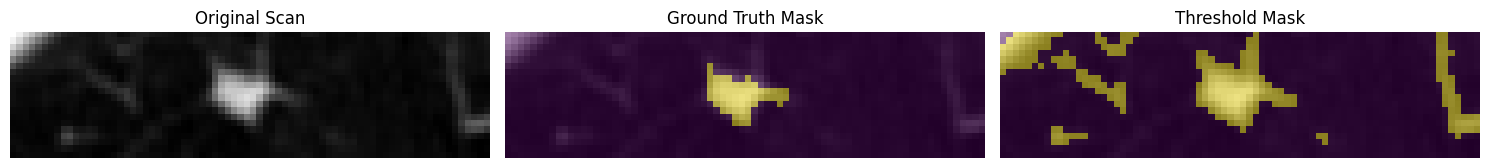

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 12))
#Original scan
axes[0].imshow(scan_slice, cmap='gray')
axes[0].set_title('Original Scan')
axes[0].axis('off')

# ground truth mask
axes[1].imshow(scan_slice, cmap='gray')
axes[1].imshow(mask_slice, cmap='viridis', alpha=0.5)
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

axes[2].imshow(scan_slice, cmap='gray')
axes[2].imshow(threshold_masks_slice, cmap='viridis', alpha=0.5)
axes[2].set_title('Threshold Mask')
axes[2].axis('off')

fig.tight_layout()
plt.savefig('drive/MyDrive/A2_coursework/threshold_mask.png')
plt.show()

Exercise 3.2

Label 1: healthy

Label 2: lung tumor

Label 3: metastatic tumor

In [ ]:
def energy(voxel_values):
    '''
    Calculate the energy of the voxel values
    
    Parameters:
    - voxel_values (np.array): The voxel values
    
    Returns:
    - energy (float): The energy of the voxel values
    '''
    return np.sum(voxel_values**2)

def mad(voxel_values):
  '''
  Calculate the mean absolute deviation of the voxel values

  Parameters:
  - voxel_values (np.array): The voxel values

  Returns:
  - mad_value (float): The mean absolute deviation of the voxel
  '''
  
  mean_value = np.mean(voxel_values)
  mad_value = np.mean(np.abs(voxel_values - mean_value))
  return mad_value

def uniformity(voxel_values,num_bins):
    '''
    Calculate the uniformity of the voxel values

    Parameters:
    - voxel_values (np.array): The voxel values
    - num_bins (int): The number of bins to use for the histogram

    Returns:
    - uniformity (float): The uniformity of the voxel values
    '''
    hist, _ = np.histogram(voxel_values, bins=num_bins, density=False)

    # Normalize histogram
    p = hist / len(voxel_values)

    # Calculate uniformity
    return np.sum(p**2)

In [ ]:
def normalize_intensity(voxel_data):
    '''
    Normalize the intensity values of the voxel data
    
    Parameters:
    - voxel_data (np.array): The voxel data
    
    Returns:
    - normalized_data (np.array): The normalized voxel data
    '''
    min_val = np.min(voxel_data)
    max_val = np.max(voxel_data)
    return (voxel_data - min_val) / (max_val - min_val)

Determine bins with Scott's rule:

In [ ]:
labels_df = pd.read_csv(os.path.join(data_dir, 'labels.csv'))

In [ ]:
intensity_ranges = []
bins_count = []
for patient_id in patient_ids:
  patient_num = patient_id.split('_')[1]
  diagnosis = labels_df.loc[labels_df['ID'] == int(patient_num), 'Diagnosis'].values

  if diagnosis != 1:
    scan, mask = load_patient_data(patient_id, data_dir)
    voxel_values = scan[mask > 0]
    intensities = normalize_intensity(voxel_values)

    min_int = np.min(intensities)
    max_int = np.max(intensities)
    intensity_ranges.append((min_int,max_int))

    bins = int(np.ceil((max_int - min_int) / (3.5 * np.std(intensities) / len(intensities)**(1/3))))
    bins_count.append(bins)



In [ ]:
bins_number = int(np.mean(bins_count))
print(bins_number)

28


In [ ]:
features = {}
for patient_id in tqdm(patient_ids):
    scans, mask = load_patient_data(patient_id, data_dir)
    scan = normalize_intensity(scan)

    intensities = scans[mask > 0]

    energy_val = energy(intensities)
    mad_val = mad(intensities)
    uniformity_val = uniformity(intensities, num_bins=bins_number)
    features[patient_id] = [energy_val, mad_val, uniformity_val]



100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


In [ ]:
#created a dataframe for all the statistics
df = pd.DataFrame.from_dict(features, orient='index')
df.columns = ['Energy','Mean Absolute Deviation','Uniformity']
df = df.round({'Energy': 2, 'Mean Absolute Deviation': 2, 'Uniformity': 2})
df.reset_index(inplace=True)
df.rename(columns={'index': 'Case_ID'}, inplace=True)
print(df.head())

   Case_ID       Energy  Mean Absolute Deviation  Uniformity
0  case_11  965718972.0                    47.67        0.09
1   case_1   57513797.0                   106.04        0.13
2   case_0   27673733.0                   189.50        0.04
3  case_10    6673689.0                   274.03        0.06
4  case_12    2368756.0                   118.83        0.05
